In [1]:
import os, sys
import importlib
import json
import glob
import logging
from typing import *

import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

SRC_DIR = os.path.join(os.path.dirname(os.getcwd()), "tcr")
assert os.path.isdir(SRC_DIR)
sys.path.append(SRC_DIR)
import featurization as ft
import data_loader as dl
import canonical_models as models
import model_utils
import plot_utils
import utils

# Controls whether the notebook is run to 
FILT_EDIT_DIST = False

if FILT_EDIT_DIST:
    PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots/lcmv_test_set_edit_dist_filt")
else:
    PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots/lcmv_test_set")
if not os.path.isdir(PLOT_DIR):
    os.makedirs(PLOT_DIR)

INFO:matplotlib.font_manager:Failed to extract font properties from /usr/share/fonts/truetype/noto/NotoColorEmoji.ttf: In FT2Font: Could not set the fontsize (error code 0x17)


In [2]:
lcmv_table = dl.load_lcmv_table()
lcmv_table.head()

INFO:root:Loaded in table of 20351 entries
INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:root:16768 entries remain after dropping na
INFO:root:15028 entries remain after dropping unsorted
INFO:root:20522 entries after expanding multiple entries
INFO:root:Class TetPos: 1819
INFO:root:Class TetNeg: 17477
INFO:root:Class TetMid: 1226


,tetramer,tcr_cdr3s_aa,tcr_cdr3s_nt,TRB,TRA,nCells,Prop,TRA_nt,TRB_nt,antigen.sequence,...,S.Score,G2M.Score,Phase,phenotype,v_a_gene,d_a_gene,j_a_gene,v_b_gene,d_b_gene,j_b_gene
0,TetPos,TRA:CAFEVVGQLTF;TRB:CASSFRDSSYEQYF,TRA:TGTGCTTTCGAGGTTGTGGGGCAGCTCACTTTC;TRB:TGTG...,CASSFRDSSYEQYF,CAFEVVGQLTF,3728,0.994664,TGTGCTTTCGAGGTTGTGGGGCAGCTCACTTTC,TGTGCCAGCAGTTTCAGGGACAGCTCCTATGAACAGTACTTC,KAVYNFATC,...,-0.010752,-0.050206,G1,TEx,TRAV16N,None,TRAJ5,TRBV14,None,TRBJ2-7
1,TetPos,TRA:CAVSAWVGDNSKLIW;TRB:CASSRDSLTEVFF,TRA:TGCGCAGTCAGTGCATGGGTTGGTGACAACAGTAAGCTGATT...,CASSRDSLTEVFF,CAVSAWVGDNSKLIW,1805,0.981512,TGCGCAGTCAGTGCATGGGTTGGTGACAACAGTAAGCTGATTTGG,TGTGCCAGCAGCCGGGACAGCTTGACAGAAGTCTTCTTT,KAVYNFATC,...,-0.100078,-0.016706,G1,TEx,TRAV3D-3,None,TRAJ38,TRBV3,None,TRBJ1-1
2,TetPos,TRA:CAQLEGADRLTF;TRB:CASSDHTNTEVFF,TRA:TGTGCTCAGTTAGAAGGTGCAGATAGACTCACCTTT;TRB:T...,CASSDHTNTEVFF,CAQLEGADRLTF,1299,0.999231,TGTGCTCAGTTAGAAGGTGCAGATAGACTCACCTTT,TGTGCCAGCAGTGATCACACAAACACAGAAGTCTTCTTT,KAVYNFATC,...,-0.112835,-0.128558,G1,TEx_progenitor,TRAV6-7-DV9,None,TRAJ45,TRBV13-3,None,TRBJ1-1
3,TetNeg,TRA:CAMSDLSNNAGAKLTF;TRB:CASSRDNNYAEQFF,TRA:TGTGCTATGAGTGATCTGAGTAATAATGCAGGTGCCAAGCTC...,CASSRDNNYAEQFF,CAMSDLSNNAGAKLTF,954,0.947368,TGTGCTATGAGTGATCTGAGTAATAATGCAGGTGCCAAGCTCACATTC,TGTGCTAGCAGCCGGGACAATAACTATGCTGAGCAGTTCTTC,KAVYNFATC,...,-0.075815,-0.128061,G1,TEx,TRAV6D-3,None,TRAJ39,TRBV17,None,TRBJ2-1
4,TetNeg,TRA:CALGLYGNEKITF;TRB:CASSVTSANTEVFF,TRA:TGTGCTCTGGGTCTCTATGGAAATGAGAAAATAACTTTT;TR...,CASSVTSANTEVFF,CALGLYGNEKITF,894,0.951064,TGTGCTCTGGGTCTCTATGGAAATGAGAAAATAACTTTT,TGTGCCAGCAGCGTGACAAGTGCAAACACAGAAGTCTTCTTT,KAVYNFATC,...,-0.129156,-0.089390,G1,TEx_transitory,TRAV6N-7,None,TRAJ48,TRBV10,None,TRBJ1-1


In [3]:
lcmv_dedup_tra_trb, lcmv_dedup_labels = dl.dedup_lcmv_table(lcmv_table)
lcmv_dedup_tra, lcmv_dedup_trb = zip(*lcmv_dedup_tra_trb)
lcmv_dedup = pd.DataFrame(
    {
        "TRA": lcmv_dedup_tra,
        "TRB": lcmv_dedup_trb,
        "tetramer": lcmv_dedup_labels,
        "label": ["TetPos" in l or "TetMid" in l for l in lcmv_dedup_labels],
    }
)
lcmv_dedup.head()

INFO:root:Deduped from 20522 -> 17772 merging 101 labels
INFO:root:Combined labels [('TetNeg', 15396), ('TetPos', 1216), ('TetMid', 1059), ('TetMid,TetNeg', 55), ('TetMid,TetPos', 31), ('TetNeg,TetPos', 14), ('TetMid,TetNeg,TetPos', 1)]
INFO:root:Filtering out labels ('TetMid,TetNeg', 'TetNeg,TetPos', 'TetMid,TetNeg,TetPos')
INFO:root:Retaining 17702 pairs with unambiguous labels
INFO:root:LCMV deduped labels: [('TetNeg', 15396), ('TetPos', 1216), ('TetMid', 1059), ('TetMid,TetPos', 31)]


,TRA,TRB,tetramer,label
0,CAAAAAGNYKYVF,CASSLLGGSYEQYF,TetNeg,False
1,CAAAASNTNKVVF,CASSLGLGANTGQLYF,TetNeg,False
2,CAAAASSGSWQLIF,CASGPREANERLFF,TetNeg,False
3,CAAADNYAQGLTF,CASGEGPDYTF,TetNeg,False
4,CAAADNYAQGLTF,CASRDWGDEQYF,TetNeg,False


In [4]:
lcmv_valid = dl.split_arr(lcmv_dedup, 'valid')
lcmv_test = dl.split_arr(lcmv_dedup, 'test')
lcmv_test_labels = np.array(list(lcmv_test['label']))
lcmv_test.head()

,TRA,TRB,tetramer,label
15519,CAVSLGSALGRLHF,CASSLDWVSYEQYF,TetNeg,False
12676,CATDASQGGRALIF,CASSSGGSQNTLYF,TetNeg,False
11471,CAMREMDSNYQLIW,CASSLGLGTNTGQLYF,TetNeg,False
16890,CIVTDMSSNNRIFF,CASSETGTNSDYTF,TetNeg,False
2564,CAASENSGTYQRF,CGAREGFEQYF,TetMid,True


In [5]:
np.mean(lcmv_test_labels)

0.1224105461393597

In [6]:
# Define the training set and remove elements too similar to test set
importlib.reload(dl)

def remove_similar_train_df(train_df, test_df, min_dist:int = 3) -> pd.DataFrame:
    """
    Return a deduped version of the training df based on edit distance to any sequence
    pair in the test df
    """
    dists = dl.min_dist_train_test_pairs(
        list(zip(train_df['TRA'], train_df['TRB'])),
        list(zip(test_df['TRA'], test_df['TRB'])),
    )
    accept_idx = np.where(dists >= min_dist)[0]
    logging.info(f"Retaining {len(accept_idx)}/{len(train_df)} sequences that have >= {min_dist} total edit dist")
    return train_df.iloc[accept_idx]


lcmv_train = dl.split_arr(lcmv_dedup, 'train')
if FILT_EDIT_DIST:
    lcmv_train = remove_similar_train_df(lcmv_train, lcmv_test)
lcmv_train

,TRA,TRB,tetramer,label
4178,CAAVSNYNVLYF,CGARDRDNANTEVFF,TetNeg,False
4114,CAATSSGQKLVF,CASGETANSDYTF,TetNeg,False
8621,CALSDTGNYKYVF,CGGQGGAETLYF,TetNeg,False
3803,CAASTPTEGADRLTF,CASNNWGDEQYF,TetNeg,False
6509,CALGGYGNEKITF,CASSSTGTNTEVFF,TetNeg,False
...,...,...,...,...
3469,CAASPSSGSWQLIF,CASSTGGQNTLYF,TetNeg,False
6363,CALGETEGADRLTF,CTCSADGWGYEQYF,TetPos,True
7786,CALSAGTGGYKVVF,CASSRQGAGYAEQFF,TetNeg,False
5611,CALGATEGADRLTF,CASSLLWDSGNTLYF,TetPos,True


# Embedding based approaches

In [7]:
def get_tcrbert_ab_embed(df, layer=-1):
    """Given a df with TRA and TRB sequences, return the embedding"""
    retval = np.hstack([
        model_utils.get_transformer_embeddings(
            "wukevin/tcr-bert-mlm-only",
            df['TRA'],
            method='mean',
            layers=[layer],
            device=3,
        ),
        model_utils.get_transformer_embeddings(
            "wukevin/tcr-bert",
            df['TRB'],
            method='mean',
            layers=[layer],
            device=3,
        )
    ])
    return retval

def get_embedding_based_test_preds(
    embed_func:Callable,
    model=models.ModelOnPCA(SVC, probability=True, kernel='rbf')
):
    """
    Return the test set preds for a given embedding function, whose embeddings
    are then used to train a classifier

    embed_func should take in a data frame and return a embedding array
    model should support .fit and .predict_proba
    """
    train_embed = embed_func(lcmv_train)
    test_embed = embed_func(lcmv_test)

    model.fit(train_embed, lcmv_train['label'])
    retval = model.predict_proba(test_embed)[:, 1].squeeze()
    logging.info(f"{type(model)} test set AUPRC: {metrics.average_precision_score(lcmv_test['label'], retval)}")
    return retval

tcrbert_lcmv_test_preds = get_embedding_based_test_preds(
    get_tcrbert_ab_embed,
    # models.ModelOnPCA(SVC, probability=True, kernel='rbf', n_components=0.9),
    SVC(probability=True, kernel='rbf', random_state=6489),
)

Some weights of the model checkpoint at wukevin/tcr-bert were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at wukevin/tcr-bert were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS

In [8]:
def get_tape_ab_embed(df):
    """
    Get TAPE's embedding of TRA and TRB sequences
    """
    a_embed = model_utils.get_tape_embedding(df['TRA'])
    b_embed = model_utils.get_tape_embedding(df['TRB'])
    retval = np.hstack([a_embed, b_embed])
    return retval

tape_lcmv_test_preds = get_embedding_based_test_preds(
    get_tape_ab_embed,
    # models.ModelOnPCA(SVC, probability=True, kernel='rbf', n_components=0.9),
    SVC(probability=True, kernel='rbf', random_state=6489),
)

INFO:root:TAPE command: CUDA_VISIBLE_DEVICES=3 tape-embed unirep /tmp/tmpch488ljg/input.fasta /tmp/tmpch488ljg/output.npz babbler-1900 --tokenizer unirep --seed 1234
INFO:root:TAPE command: CUDA_VISIBLE_DEVICES=3 tape-embed unirep /tmp/tmpovakcrqx/input.fasta /tmp/tmpovakcrqx/output.npz babbler-1900 --tokenizer unirep --seed 1234
INFO:root:TAPE command: CUDA_VISIBLE_DEVICES=3 tape-embed unirep /tmp/tmpdjyci4in/input.fasta /tmp/tmpdjyci4in/output.npz babbler-1900 --tokenizer unirep --seed 1234
INFO:root:TAPE command: CUDA_VISIBLE_DEVICES=3 tape-embed unirep /tmp/tmpca92n1b8/input.fasta /tmp/tmpca92n1b8/output.npz babbler-1900 --tokenizer unirep --seed 1234
INFO:root:<class 'sklearn.svm._classes.SVC'> test set AUPRC: 0.4261314776216939


In [9]:
importlib.reload(model_utils)

def get_esm_ab_embed(df):
    """
    Get ESM's embedding of TRA/TRB sequences
    """
    a_embed = model_utils.get_esm_embedding(df['TRA'])
    b_embed = model_utils.get_esm_embedding(df['TRB'])
    return np.hstack([a_embed, b_embed])

esm_lcmv_test_preds = get_embedding_based_test_preds(
    get_esm_ab_embed,
    # models.ModelOnPCA(SVC, probability=True, kernel='rbf', n_components=0.9),
    SVC(probability=True, kernel='rbf', random_state=6489),
)

Using cache found in /home/wukevin/.cache/torch/hub/facebookresearch_esm_master
Using cache found in /home/wukevin/.cache/torch/hub/facebookresearch_esm_master
Using cache found in /home/wukevin/.cache/torch/hub/facebookresearch_esm_master
Using cache found in /home/wukevin/.cache/torch/hub/facebookresearch_esm_master
INFO:root:<class 'sklearn.svm._classes.SVC'> test set AUPRC: 0.37877296652547193


In [10]:
# Load this once
DEEPTCR_ALL_EMBED = np.load(os.path.join(
    os.path.dirname(SRC_DIR), "external_eval/deeptcr_embeds/lcmv_deeptcr_embed.npy"
))
assert DEEPTCR_ALL_EMBED.shape[0] == lcmv_dedup.shape[0]

def get_deeptcr_embed(df):
    """
    Get deepTCR's embedding of the TRA/TRB sequences. This is more complex since deepTCR
    is run in a separate notebook with its results saved
    """
    full_ab_combos = list(zip(lcmv_dedup['TRA'], lcmv_dedup['TRB']))
    assert utils.is_all_unique(full_ab_combos)
    ab_combos = list(zip(df['TRA'], df['TRB']))
    assert utils.is_all_unique(ab_combos)

    indices = [full_ab_combos.index(pair) for pair in ab_combos]
    return DEEPTCR_ALL_EMBED[indices]
    
deeptcr_lcmv_test_preds = get_embedding_based_test_preds(
    get_deeptcr_embed,
    # models.ModelOnPCA(SVC, probability=True, kernel='rbf', n_components=0.9),
    SVC(probability=True, kernel='rbf', random_state=6489),
)

INFO:root:<class 'sklearn.svm._classes.SVC'> test set AUPRC: 0.3980650915707973


In [11]:
# Get the embedding for k-mers

def get_kmer_embed(df):
    """
    Get k-mer embedding of TRA/TRB sequences. This serves as a baseline method
    """
    a_embed = [ft.kmer_ft(seq) for seq in df['TRA']]
    b_embed = [ft.kmer_ft(seq) for seq in df['TRB']]
    retval = np.hstack([a_embed, b_embed])
    assert retval.shape[0] == len(df)
    return retval

lr_baseline_lcmv_test_preds = get_embedding_based_test_preds(
    get_kmer_embed,
    # models.ModelOnPCA(SVC, probability=True, kernel='rbf', n_components=100),
    LogisticRegression(solver='liblinear'),
)

INFO:root:<class 'sklearn.linear_model._logistic.LogisticRegression'> test set AUPRC: 0.4514640213770017


INFO:root:AUPRC of 0.4662
INFO:root:AUPRC of 0.3788
INFO:root:AUPRC of 0.4261
INFO:root:AUPRC of 0.3981
INFO:root:AUROC of 0.7428
INFO:root:AUROC of 0.6966
INFO:root:AUROC of 0.7239
INFO:root:AUROC of 0.7202


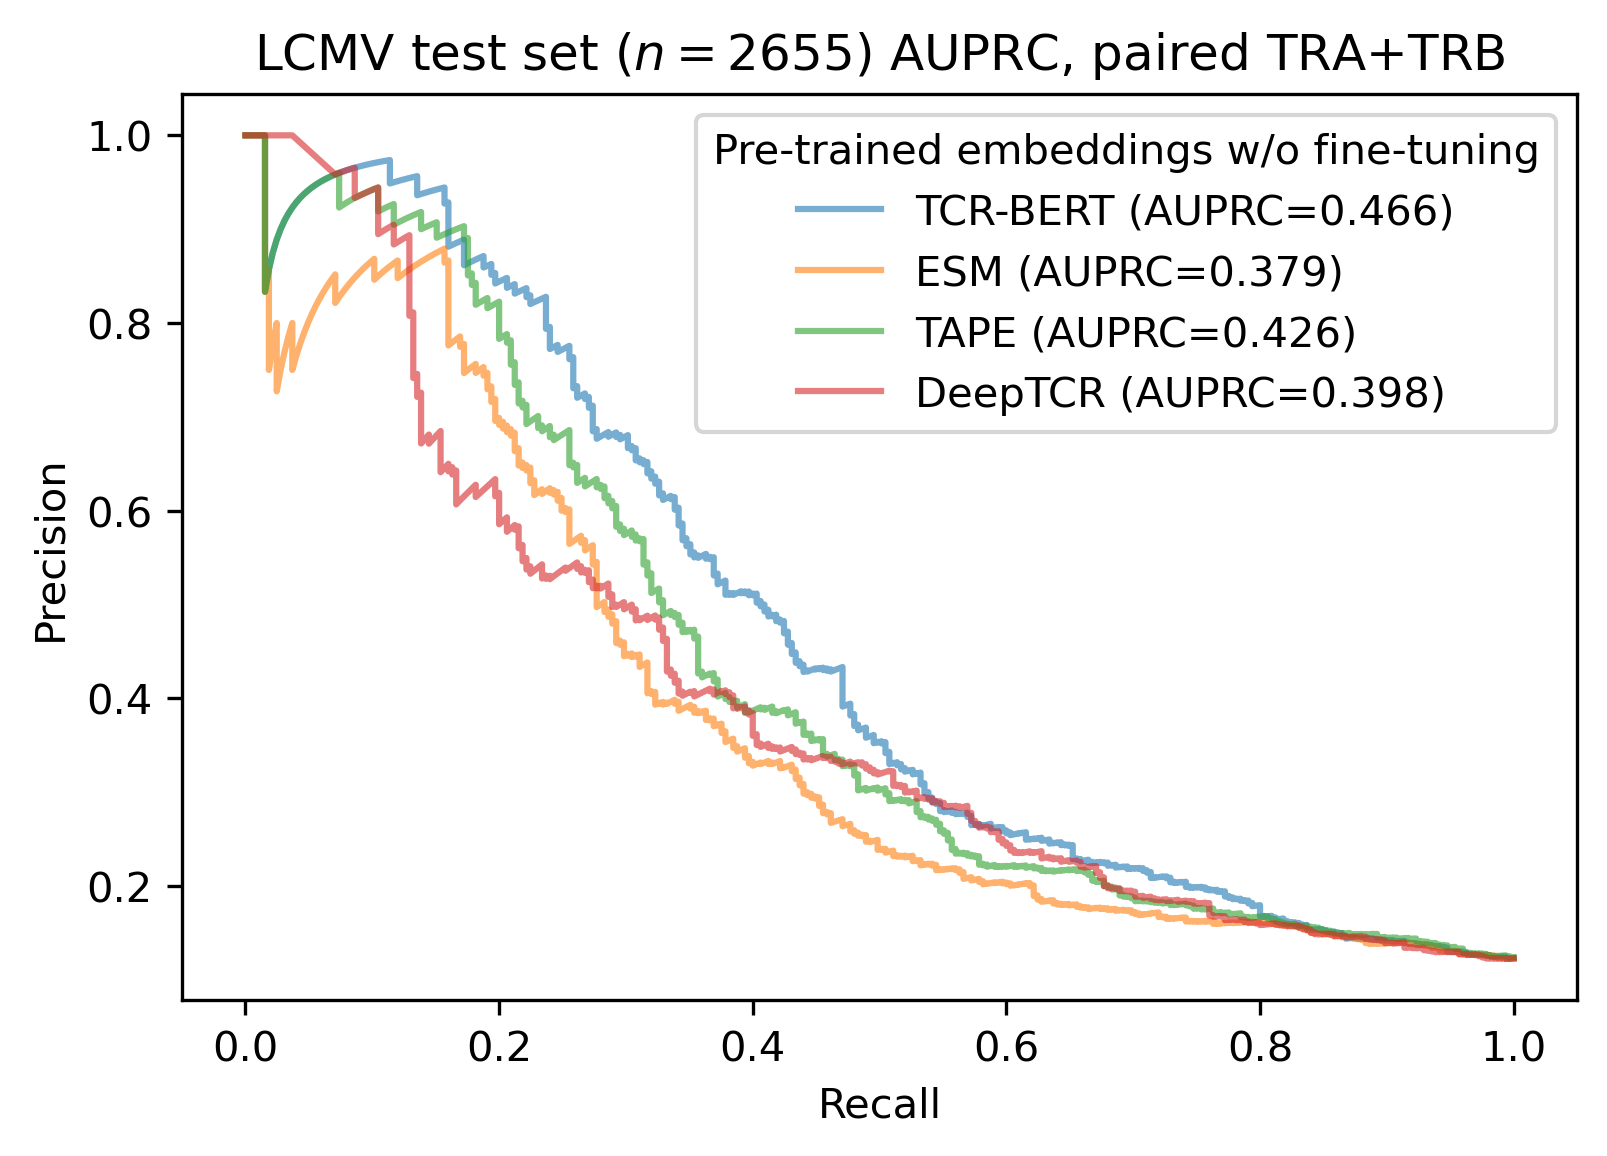

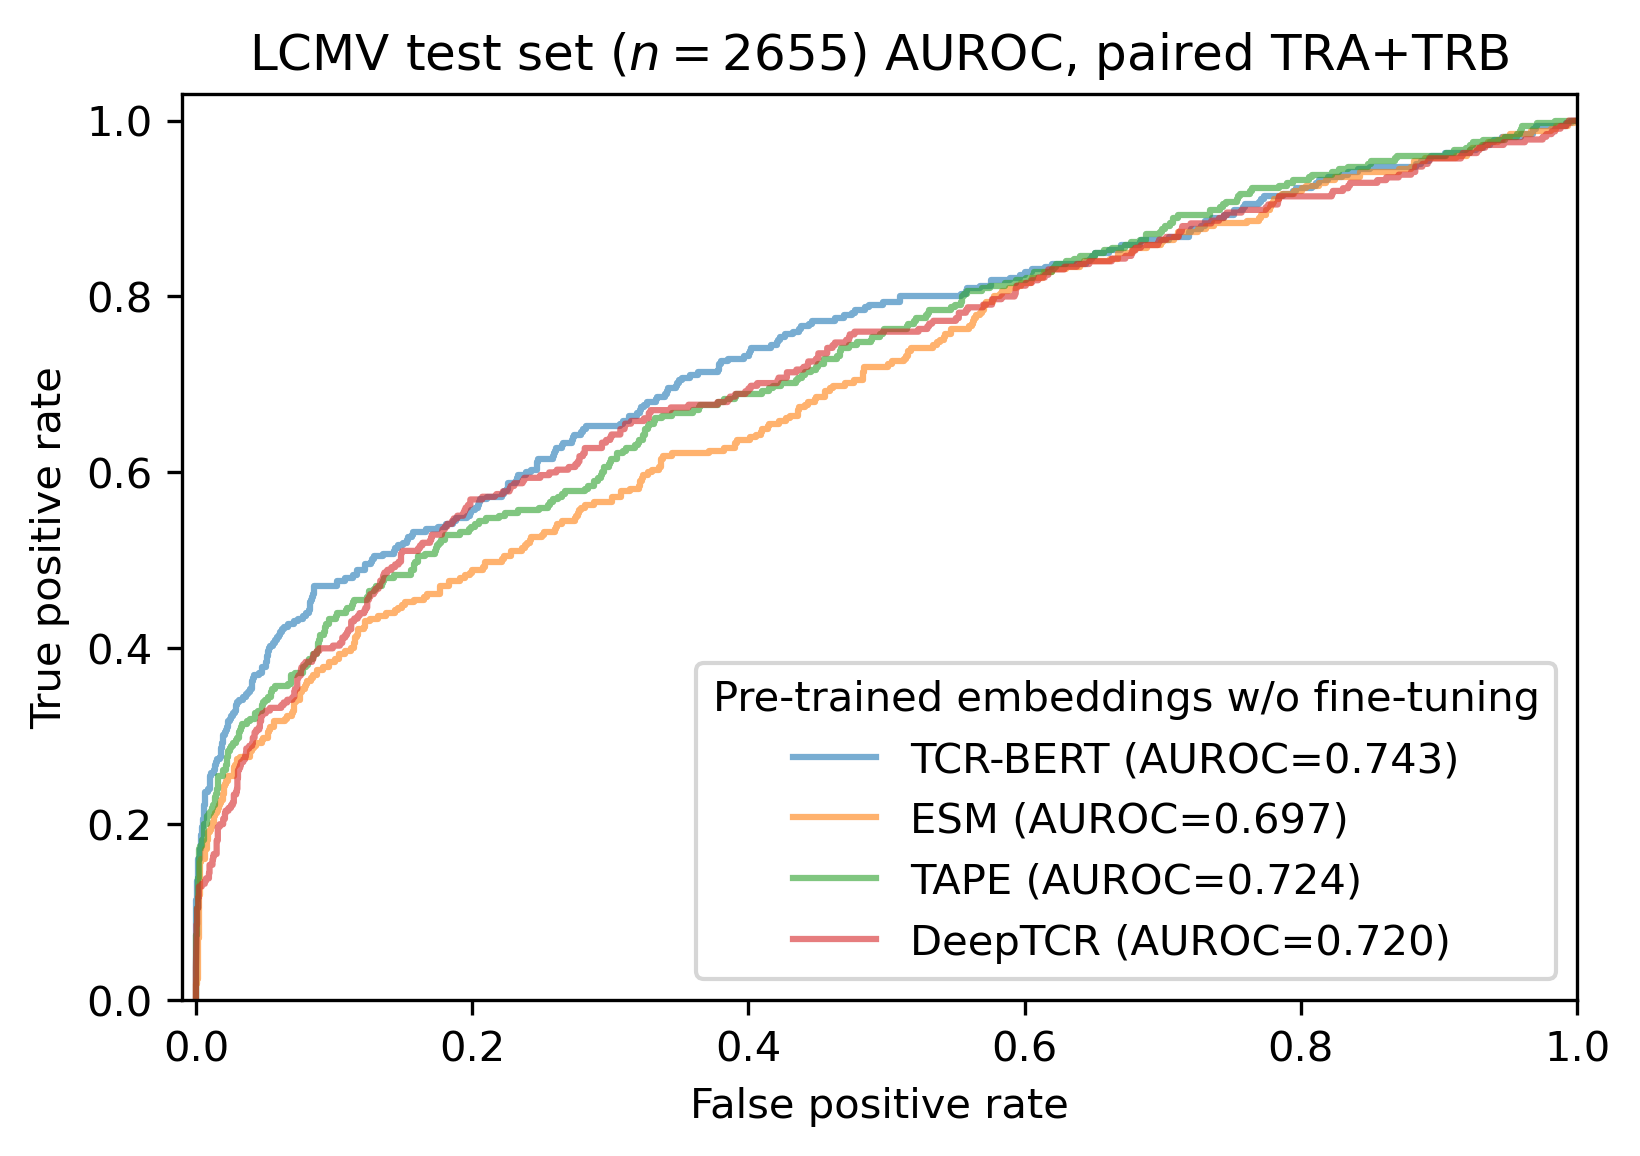

In [12]:
# plot the results of the embedding based models

plotter_dict = {'auprc': plot_utils.plot_auprc, 'auroc': plot_utils.plot_auroc}
for plot_metric, plot_func in plotter_dict.items():
    fig, ax = plt.subplots(dpi=300)
    plot_func(
        lcmv_test['label'],
        tcrbert_lcmv_test_preds,
        label_prefix="TCR-BERT",
        alpha=0.6,
        ax=ax,
    )
    plot_func(
        lcmv_test['label'],
        esm_lcmv_test_preds,
        label_prefix="ESM",
        alpha=0.6,
        ax=ax,
    )
    plot_func(
        lcmv_test['label'],
        tape_lcmv_test_preds,
        label_prefix="TAPE",
        alpha=0.6,
        ax=ax,
    )
    plot_func(
        lcmv_test['label'],
        deeptcr_lcmv_test_preds,
        label_prefix="DeepTCR",
        alpha=0.6,
        ax=ax,
    )
    ax.legend(title="Pre-trained embeddings w/o fine-tuning")

    ax.set(
        title=f"LCMV test set ($n={len(lcmv_test)}$) {plot_metric.upper()}, paired TRA+TRB",
    )
    fig.savefig(os.path.join(PLOT_DIR, f"lcmv_test_embed_only_{plot_metric}.pdf"), bbox_inches='tight')
    fig.show()

# Trained models

In [13]:
# Read in results and plot
if FILT_EDIT_DIST:
    finetune_tcrbert_preds = np.loadtxt("/home/wukevin/projects/tcr/tcr_models/lcmv_ab_finetune_nosim/test_preds.txt")
    convnet_preds = np.loadtxt("/home/wukevin/projects/tcr/tcr_models/lcmv_ab_convnet_nosim/test_preds.txt")
else:
    finetune_tcrbert_preds = np.loadtxt("/home/wukevin/projects/tcr/tcr_models/lcmv_ab_finetune_cls_pooling_False_sharedencoder_0.2_dropout_25_epochs_3e-05_lr_linear_lrsched/test_preds.txt")
    convnet_preds = np.loadtxt("/home/wukevin/projects/tcr/tcr_models/supervised_conv_lcmv_baseline_deduped/supervised_embedded_conv/test_preds.txt")
finetune_tcrbert_preds.shape, convnet_preds.shape

((2655,), (2655,))

INFO:root:AUPRC of 0.6077
INFO:root:AUPRC of 0.3788
INFO:root:AUPRC of 0.4261
INFO:root:AUPRC of 0.3981
INFO:root:AUPRC of 0.5408
INFO:root:AUPRC of 0.4515
INFO:root:AUPRC of 0.1304
INFO:root:AUROC of 0.8374
INFO:root:AUROC of 0.6966
INFO:root:AUROC of 0.7239
INFO:root:AUROC of 0.7202
INFO:root:AUROC of 0.7841
INFO:root:AUROC of 0.7507


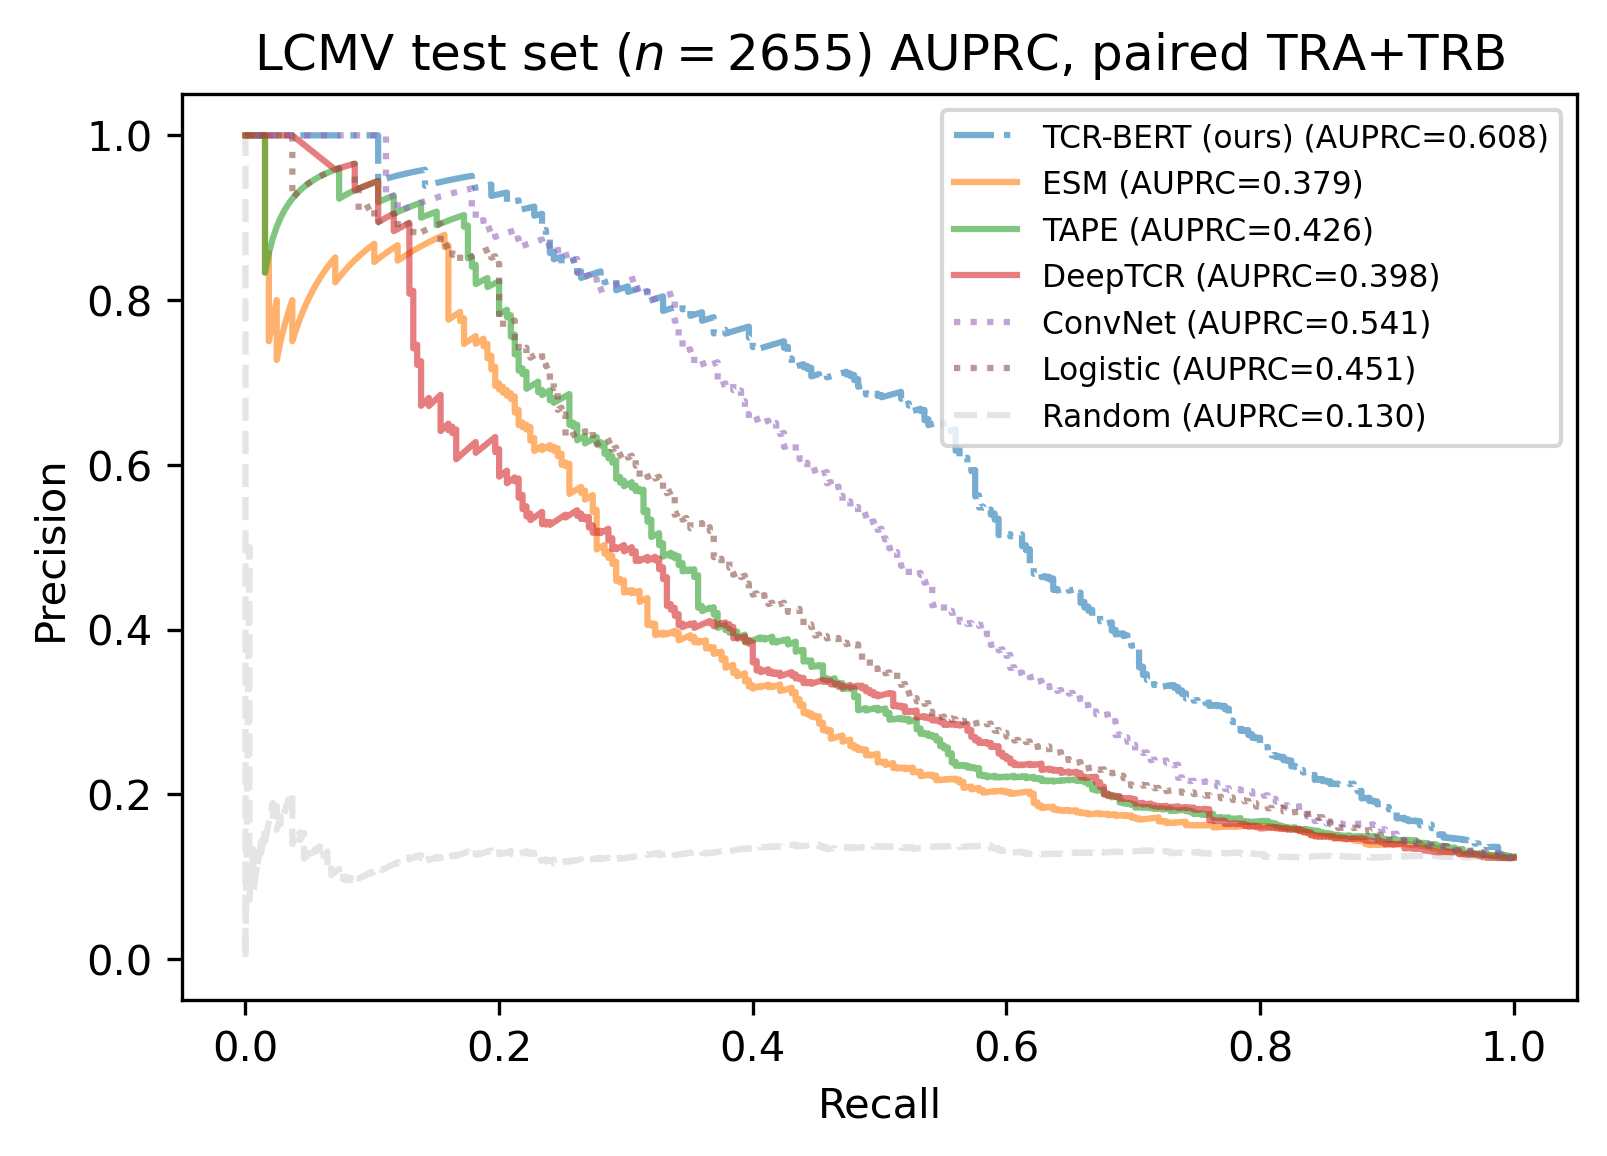

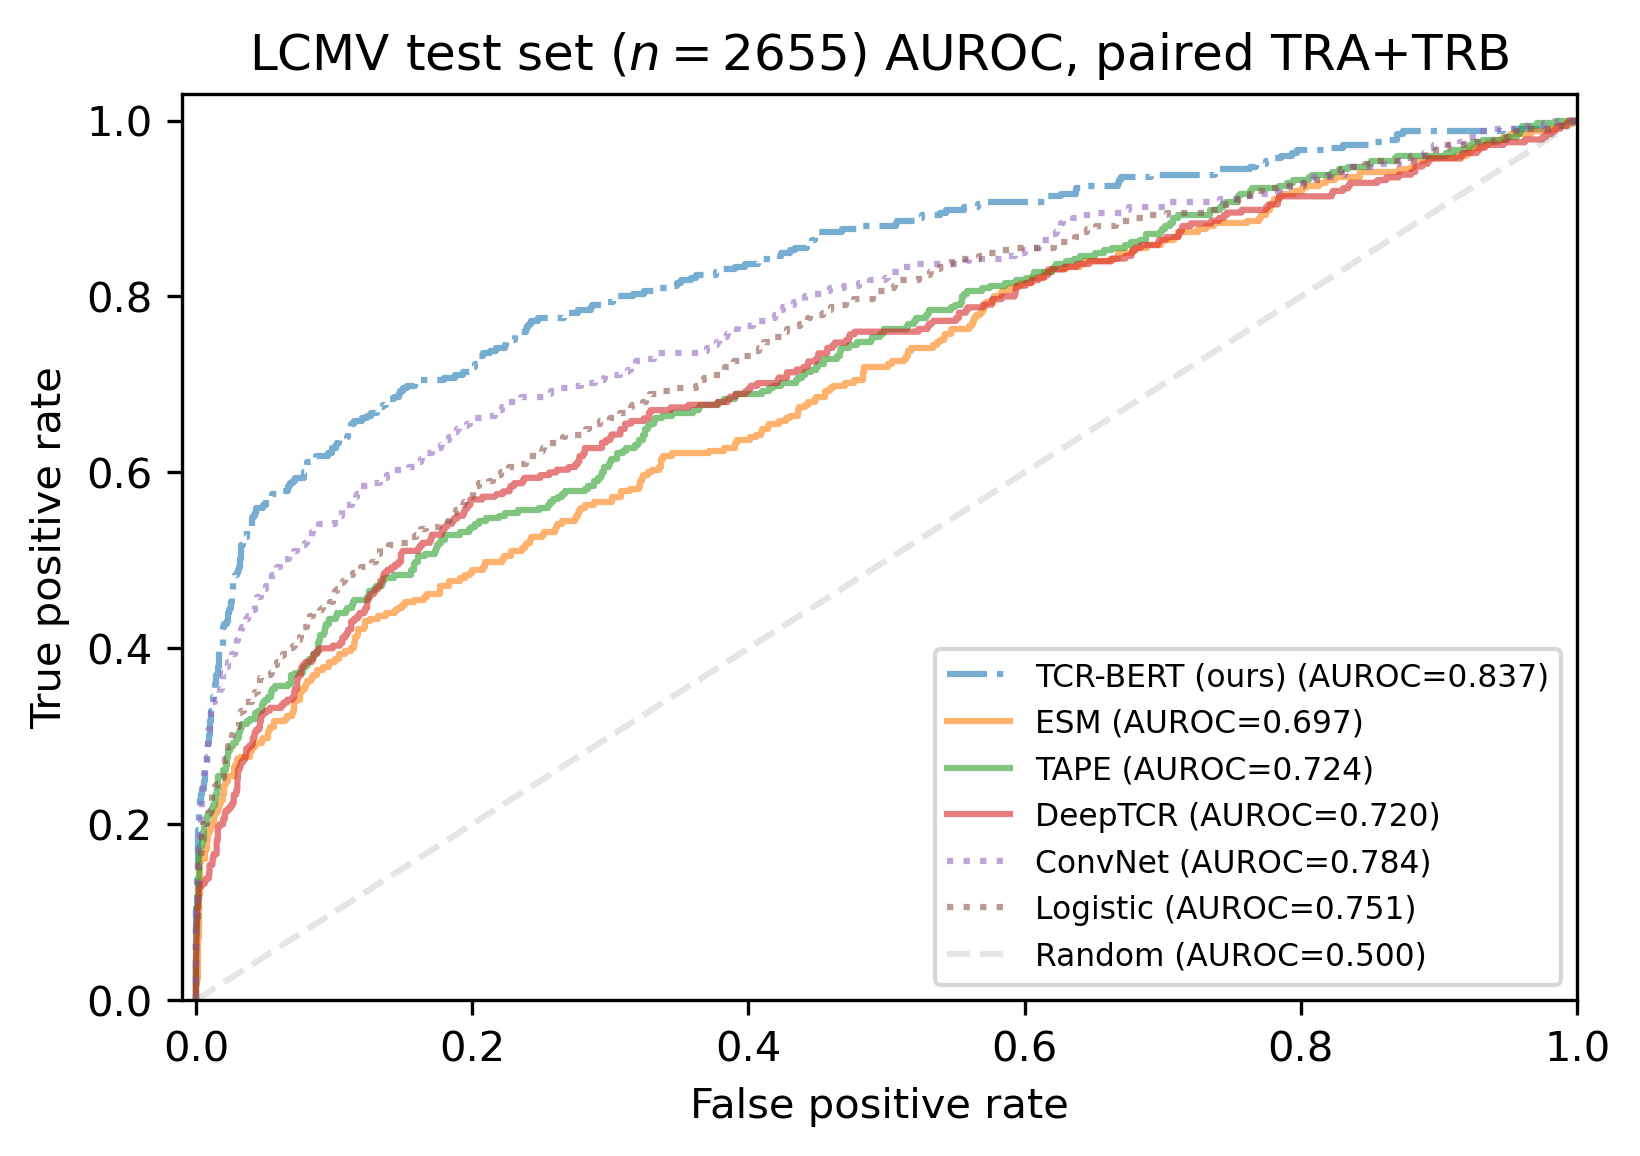

In [14]:
# plot the results of the embedding based models

for plot_metric, plot_func in plotter_dict.items():
    fig, ax = plt.subplots(dpi=300)
    plot_func(
        lcmv_test['label'],
        finetune_tcrbert_preds,
        label_prefix="TCR-BERT (ours)",
        alpha=0.6, linestyle="-.",
        ax=ax,
    )

    plot_func(
        lcmv_test['label'],
        esm_lcmv_test_preds,
        label_prefix="ESM",
        alpha=0.6,
        ax=ax,
    )
    plot_func(
        lcmv_test['label'],
        tape_lcmv_test_preds,
        label_prefix="TAPE",
        alpha=0.6,
        ax=ax,
    )
    plot_func(
        lcmv_test['label'],
        deeptcr_lcmv_test_preds,
        label_prefix="DeepTCR",
        alpha=0.6,
        ax=ax,
    )
    # plot_utils.plot_auprc(
    #     lcmv_test['label'],
    #     tcrbert_lcmv_test_preds,
    #     label_prefix="TCR-BERT",
    #     alpha=0.6, linestyle="--",
    #     ax=ax,
    # )
    ###
    plot_func(
        lcmv_test['label'],
        convnet_preds,
        label_prefix="ConvNet",
        alpha=0.6, linestyle='dotted',
        ax=ax,
    )
    plot_func(
        lcmv_test['label'],
        lr_baseline_lcmv_test_preds,
        label_prefix="Logistic",
        alpha=0.6, linestyle='dotted',
        ax=ax,
    )
    ###
    if plot_metric == "auprc":
        rand_line_rng = np.random.default_rng(seed=6489)
        plot_utils.plot_auprc(
            lcmv_test['label'],
            rand_line_rng.random(size=len(lcmv_test)),
            label_prefix="Random",
            alpha=0.2, linestyle="dashed", color="grey",
            ax=ax,
        )
    else:
        ax.plot(
            [0, 1], [0, 1],
            label="Random (AUROC=0.500)",
            alpha=0.2, linestyle="dashed", color="grey",
        )

    ax.legend(prop={"size": 7.5})
    ax.set(
        title=f"LCMV test set ($n={len(lcmv_test)}$) {plot_metric.upper()}, paired TRA+TRB"
    )
    fig.savefig(os.path.join(PLOT_DIR, f"lcmv_test_{plot_metric}.pdf"), bbox_inches='tight')
    fig.show()